## ML: Autoencoder

In [36]:
import pandas as pd

# Loading the provided data file to inspect its contents
file_path = r'/Users/emmanuel_bamidele/Desktop/Bamspace/Data_Science_Tutorial/Books/Software for STEM Grad Students/Data/ML_Autoencoder_laptops.csv'
laptop_data = pd.read_csv(file_path)

# Displaying the first few rows of the dataset to understand its structure and contents
laptop_data.head()


,CompanyName,TypeOfLaptop,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,MSI,Business Laptop,17.040680,IPS Panel Retina Display 2560x1600,Intel Core i7,12GB,512GB SSD,Intel Iris Xe Graphics,Linux,2.064834,35844.099371
1,Chuwi,2 in 1 Convertible,16.542395,Full HD,Intel Core i5,12GB,128GB PCIe SSD,Intel Iris Xe Graphics,No OS,4.060656,37019.059051
2,hp,WorkStation,17.295294,Full HD,Intel Xeon E3-1505M,8GB,1TB HDD,Intel Iris Xe Graphics,Linux,2.901689,33329.360341
3,MSI,2 in 1 Convertible,11.526203,2K,Intel Core i7,16GB,512GB NVMe SSD,Intel Iris Xe Graphics,Windows 10,2.914843,68631.102486
4,Microsoft,Gaming,12.649634,Full HD,Intel Core i5,8GB,512GB SSD,AMD Radeon RX 5600M,Windows 10,4.341995,33842.479566


In [48]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

# Preprocessing the data
# Separating numerical and categorical columns
numerical_cols = laptop_data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = laptop_data.select_dtypes(include=['object']).columns

# Creating a transformer for numerical features
numerical_transformer = StandardScaler()

# Creating a transformer for categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)  
# Ensure output is in dense format

# Bundling transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Splitting the dataset into training and testing sets
X_train, X_test = train_test_split(laptop_data, test_size=0.2, random_state=42)

# Fitting the preprocessor and transforming the training and testing data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Ensure data is in float32 format
X_train_transformed = X_train_transformed.astype('float32')
X_test_transformed = X_test_transformed.astype('float32')

# Sparse Autoencoder Architecture
input_size = X_train_transformed.shape[1]
encoding_dim = 32  # Size of encoded representations

# Input Layer
input_layer = Input(shape=(input_size,))

# Encoding Layer with sparsity
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_layer)  # L1 regularizer for sparsity

# Decoding Layer
decoded = Dense(input_size, activation='sigmoid')(encoded)

# Autoencoder Model
autoencoder = Model(input_layer, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')  # Use mean squared error for loss

# Train the autoencoder
history = autoencoder.fit(X_train_transformed, X_train_transformed,
                epochs=200,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_transformed, X_test_transformed),
                verbose=0)

# Evaluate the model
evaluation = autoencoder.evaluate(X_test_transformed, X_test_transformed, verbose=0)

# Reconstruction error
reconstruction_error = evaluation

print("Reconstruction Error:", reconstruction_error)


Reconstruction Error: 0.07099588215351105


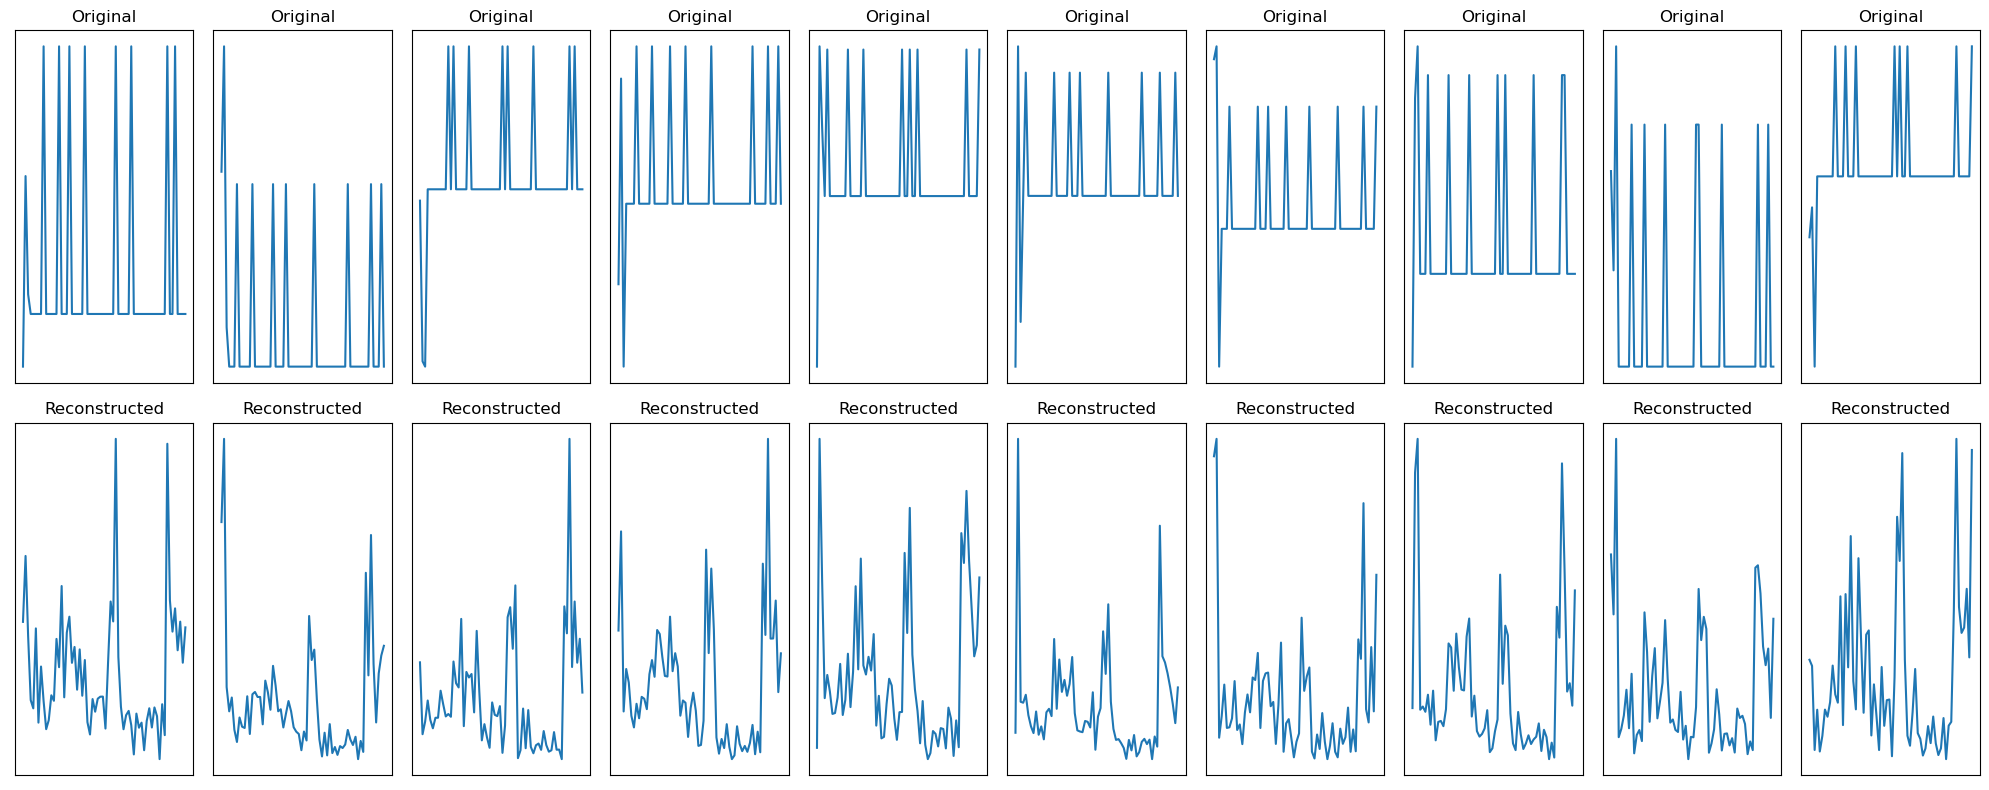

In [49]:
# Choosing a sample from the dataset for visualization (we choose the first 10 samples for simplicity)
n = 10
plt.figure(figsize=(20, 8))

for i in range(n):
    # Display original data
    ax = plt.subplot(2, n, i + 1)
    plt.plot(X_test_transformed[i])
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed data
    ax = plt.subplot(2, n, i + 1 + n)
    plt.plot(reconstructed_data[i])
    plt.title("Reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()


In [53]:
# Use the autoencoder to reconstruct the data from the transformed test set
reconstructed_data = autoencoder.predict(X_test_transformed)


# Assuming numerical_transformer is fitted as part of the ColumnTransformer pipeline
num_transformed_data = reconstructed_data[:, :len(numerical_cols)]
num_original_data = preprocessor.named_transformers_['num'].inverse_transform(num_transformed_data)

# Convert the inverse transformed numerical data to a DataFrame
reconstructed_num_df = pd.DataFrame(num_original_data, columns=numerical_cols)

# Save the numerical part of the reconstructed data to a CSV file
reconstructed_csv_path = 'reconstructed_numerical_data.csv'
reconstructed_num_df.to_csv(reconstructed_csv_path, index=False)

# Display the head of the reconstructed DataFrame
print(reconstructed_num_df.head())


7/7 [==============================] - 0s 1ms/step
      Inches    Weight         Price
0  14.751668  4.021376  53951.464844
1  16.374704  4.284381  53070.558594
2  14.568520  3.450201  51552.566406
3  14.551536  4.015235  51709.644531
4  14.502581  4.185904  59536.828125


In [57]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.losses import mse
from keras import backend as K

# Define sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# VAE Architecture
input_size = X_train_transformed.shape[1]
intermediate_dim = 64  # Size of intermediate layer
latent_dim = 32  # Size of the latent space

# Encoder architecture
inputs = Input(shape=(input_size,))
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

# Use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Instantiate the encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# Decoder architecture
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(input_size, activation='sigmoid')(x)

# Instantiate the decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# Instantiate the VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

# VAE loss = mse_loss or xent_loss + kl_loss
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= input_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Train the VAE
history = vae.fit(X_train_transformed, epochs=200, batch_size=256, 
                  validation_data=(X_test_transformed, None), verbose=0)

# Evaluate the model
evaluation = vae.evaluate(X_test_transformed, verbose=0)

# Reconstruction error
reconstruction_error = evaluation

print("Reconstruction Error:", reconstruction_error)


Reconstruction Error: 9.870149612426758


7/7 [==============================] - 0s 1ms/step


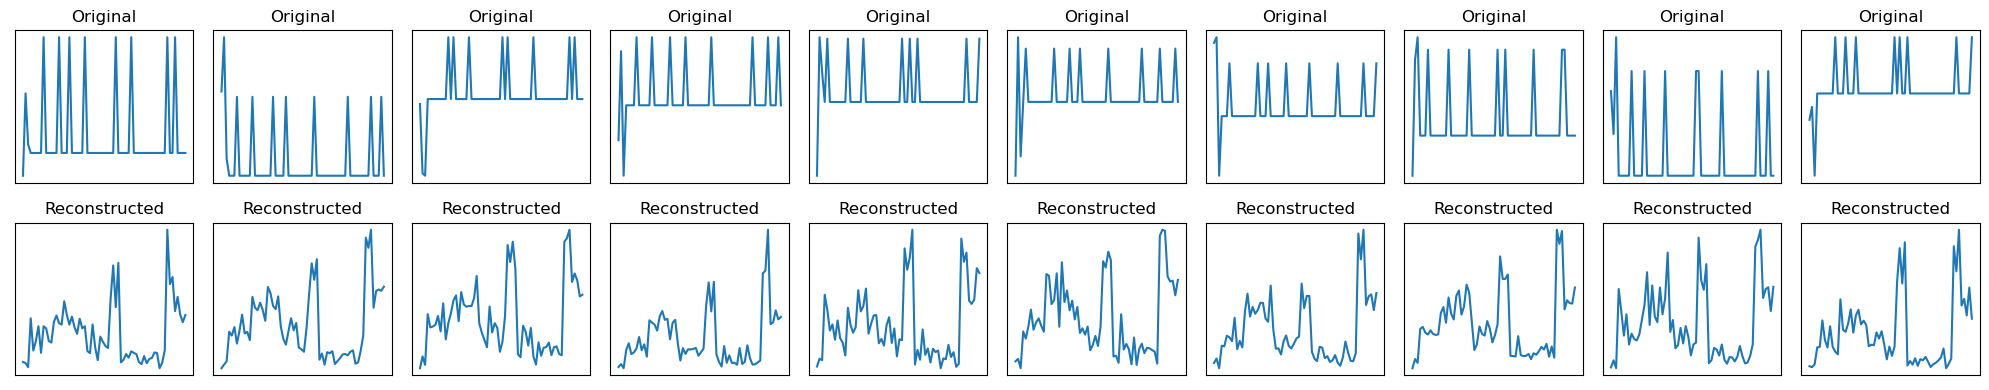

In [55]:
import matplotlib.pyplot as plt

# Predicting the reconstructed data from the VAE model
# The VAE's encoder outputs three values: mean, log-variance, and z (the latent representation)
# We use the third output (index 2) to get the latent representation for generating the reconstructed data
_, _, z_test = encoder.predict(X_test_transformed)
reconstructed_data = decoder.predict(z_test)

n = 10  # Number of samples to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Display original data
    ax = plt.subplot(2, n, i + 1)
    plt.plot(X_test_transformed[i])
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed data from VAE
    ax = plt.subplot(2, n, i + 1 + n)
    plt.plot(reconstructed_data[i])
    plt.title("Reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()
